## **Simple Black-box Adversarial Attack (SimBA) and Binary Input Detector Using MNIST-10**

This notebook demonstrates the implementation of the SimBA attack using the Adversarial Robustness Toolbox (ART) against deep learning models trained on the MNIST-10 dataset. The tasks covered in this notebook are:

1. Load the Required Libraries

    The necessary Python libraries and modules are imported, including TensorFlow/Keras for model creation and ART for implementing the adversarial attack.

2. Load the Dataset and Inspect the Data

    The MNIST-10 dataset, consisting of handwritten digits (0-9), is loaded and inspected. This step includes visualizing sample images and understanding the data distribution.

3. Create a Deep Learning Model

    A convolutional neural network (CNN) is constructed to classify the MNIST-10 digits. The architecture includes convolutional layers, pooling layers, and fully connected layers.

4. Train and Evaluate the Deep Learning Model on MNIST Test Data

    The CNN model is trained using the training set of MNIST-10 and subsequently evaluated on the test set to establish a baseline accuracy.

5. Implement SimBA Attack Using ART

    The Simple Black-box Attack (SimBA) is implemented using the ART library. SimBA is an efficient black-box adversarial attack that perturbs images by iteratively flipping the sign of individual pixels and checking the impact on the model's prediction. The attack works by querying the model to observe changes in output and does not require access to the model's internal parameters or gradients.

More about SimBA:

SimBA is particularly notable for its simplicity and effectiveness in black-box settings where only the output of the model is accessible. The attack involves:

   * Random Pixel Selection: Choosing random pixels to perturb in the input image.
   * Sign Flip: Flipping the sign of the selected pixel values to create perturbations.
   * Querying the Model: Evaluating the impact of each perturbation by querying the model and measuring the change in its output.
   * Iterative Process: Repeating the process iteratively to maximize the attack's success in causing misclassification with minimal perturbations.


6. Create Adversarial Samples Using the SimBA Attack

    Using the SimBA attack, adversarial examples are generated from the original test images. These adversarial samples are 
    visually inspected to compare them with the original images.

7. Evaluate the Deep Learning Model Against the Adversarial Samples

    The robustness of the trained CNN model is evaluated by testing its accuracy on the generated adversarial samples. This step highlights the model's vulnerability to adversarial attacks.

8. Create a Detector Model to Detect Adversarial Samples

    A binary classification model is developed to detect whether an input sample is adversarial or not. This involves designing a model that can differentiate between original and adversarial images based on specific features.

9. Train and Evaluate the Detector Model

    The detector model is trained using a labeled dataset containing both original and adversarial samples. The performance of the detector is then evaluated to determine its accuracy in identifying adversarial attacks.

----

This summary encapsulates the process and key tasks involved in implementing the SimBA attack and developing a binary input detector using the MNIST-10 dataset. The addition of the SimBA attack illustrates an effective method to evaluate the robustness of machine learning models in black-box scenarios, thereby emphasizing the importance of adversarial defenses in real-world applications.

## Install and load required libraries 

In [1]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import SimBA
from art.defences.detector.evasion import BinaryInputDetector

2024-05-24 08:52:22.431593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 08:52:22.511636: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


### Load MNIST dataset

In [25]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = np.load('./../datasets/mnist10_dataset.npy', allow_pickle = True)
x_train, x_test = x_train / 255.0, x_test / 255.0
min = x_train.min()
max = x_train.max()

x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), 0.0, 1.0)

#### Inspect the Data


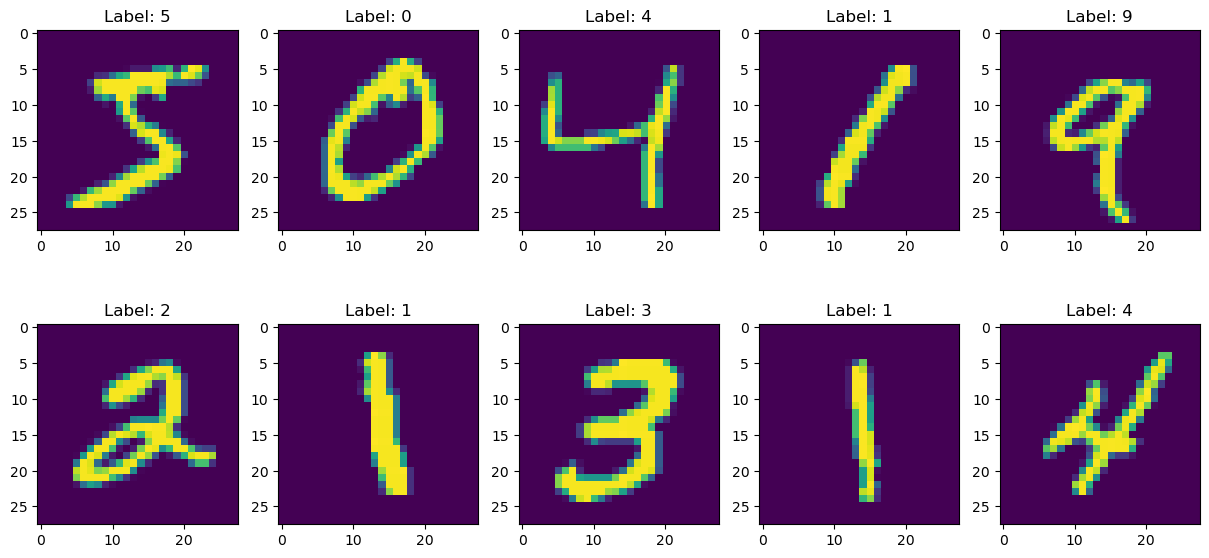

In [5]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Label: {label}",  fontsize=12)

In [26]:
nb_classes =10
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_classes)
x_test = np.expand_dims(x_test, axis=-1)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_classes)
x_train = np.expand_dims(x_train, axis=-1)

## **Training Model**

#### **Model Description**

This convolutional neural network (CNN) is designed for image classification tasks. It consists of several layers that progressively extract features from the input images and classify them into one of 10 categories.

1. Input Layer: The model accepts input images of shape (28, 28, 1).
2. Convolutional Layers:
    * First Conv Layer: 32 filters of size (3x3), activated by ReLU, followed by max pooling (2x2). 
    * Second Conv Layer: 64 filters of size (3x3), activated by ReLU, followed by max pooling (2x2).
    * Third Conv Layer: 128 filters of size (3x3), activated by ReLU, followed by max pooling (2x2).
3. Flatten Layer: Converts the 2D feature maps to a 1D feature vector.
4. Dense Layer: Fully connected layer with 128 neurons, activated by ReLU, and includes a dropout of 20% to prevent overfitting.
5. Output Layer: 10 neurons with softmax activation to classify the input image into one of the 10 categories.

The model is compiled with the Adam optimizer and uses categorical cross-entropy loss, with accuracy as the performance metric.

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']);

In [7]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

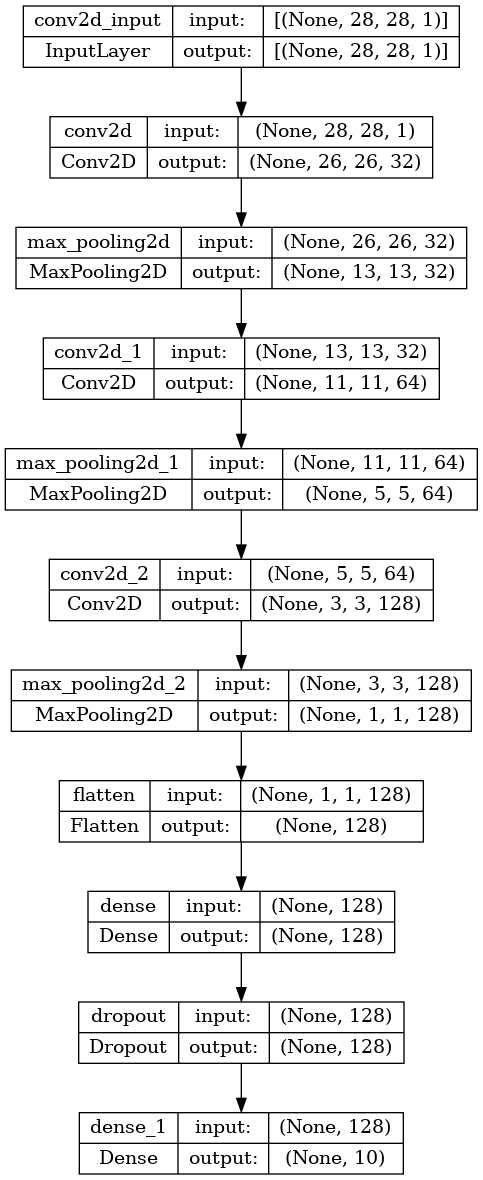

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Fit the model on training data.

In [8]:
# history = model.fit(x_train, y_train, epochs = 3)
model = tf.keras.models.load_model('./../models/mnist10_conv.keras')

2024-05-24 08:52:59.537800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45258 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5
2024-05-24 08:52:59.554692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-05-24 08:53:00.274099: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/bias/Assign' id:310 op device:{requested: '', assigned: ''} def:{{{node dense_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/bias, dense_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-24 08:53:00.463165: W tensorflow/c/c_api.cc:291] Operation '{name:'dense

#### Evaluate model accuracy on test data.

In [9]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-05-24 08:53:12.327614: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:478 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-24 08:53:12.418315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902


Accuracy on test data: 98.57%


In [27]:
x_test = x_test[0:500]
y_test = y_test[0:500]

#### Create an ART Keras classifier.

In [11]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

## **SimBA Attack**

class art.attacks.evasion.SimBA(classifier: CLASSIFIER_TYPE, attack: str = 'dct', max_iter: int = 3000, order: str = 'random', epsilon: float = 0.1, freq_dim: int = 4, stride: int = 1, targeted: bool = False, batch_size: int = 1, verbose: bool = True)

---

This class implements the black-box attack SimBA.
* Paper link: https://arxiv.org/abs/1905.07121

*__init__(classifier: CLASSIFIER_TYPE, attack: str = 'dct', max_iter: int = 3000, order: str = 'random', epsilon: float = 0.1, freq_dim: int = 4, stride: int = 1, targeted: bool = False, batch_size: int = 1, verbose: bool = True)*

**Create a SimBA (dct) attack instance.**

    Parameters
* classifier – A trained classifier predicting probabilities and not logits.
* attack (str) – attack type: pixel (px) or DCT (dct) attacks
* max_iter (int) – The maximum number of iterations.
* epsilon (float) – Overshoot parameter.
* order (str) – order of pixel attacks: random or diagonal (diag)
* freq_dim (int) – dimensionality of 2D frequency space (DCT).
* stride (int) – stride for block order (DCT).
* targeted (bool) – perform targeted attack
* batch_size (int) – Batch size (but, batch process unavailable in this implementation)
* verbose (bool) – Show progress bars.


    diagonal_order(image_size, channels)
Defines a diagonal order for pixel attacks. order is fixed across diagonals but are randomized across channels and within the diagonal e.g. [1, 2, 5] [3, 4, 8] [6, 7, 9]

    Parameters
* image_size – image size (i.e., width or height)
* channels – the number of channels

    
    Return order
* An array holding the diagonal order of pixel attacks.

    
    generate(x: ndarray, y: Optional[ndarray] = None, **kwargs) → ndarray
Generate adversarial samples and return them in an array.

    Return type
* ndarray
    
    
    Parameters
* x (ndarray) – An array with the original inputs to be attacked.
* y – An array with the true or target labels.

    
    Returns
* An array holding the adversarial examples.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#simple-black-box-adversarial-attack

### Create an ART SimBA attack.

In [12]:
attack = SimBA(classifier = classifier,
              attack = 'dct',
              max_iter = 1000,
              order = 'random',
               epsilon = 0.1,
               freq_dim = 4,
               stride = 1,
               targeted = False,
               batch_size = 1,
                verbose = False)

#### Generate adversarial test data.

In [13]:
#x_test_adv = attack.generate(x_test[1].reshape(1,28,28,1), y=y_test[1].reshape(1,10))
# x_test_adv = attack.generate(x_test, y=y_test)
# np.save('./SimBA_data/SimBA_generated_mnist_data.npz', x_test_adv)
x_test_adv = np.load('./SimBA_data/SimBA_generated_mnist_data.npy')
x_test_adv.shape

(500, 28, 28, 1)

#### Visualise the first adversarial test sample.

2024-05-24 08:53:38.310254: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/Softmax' id:349 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


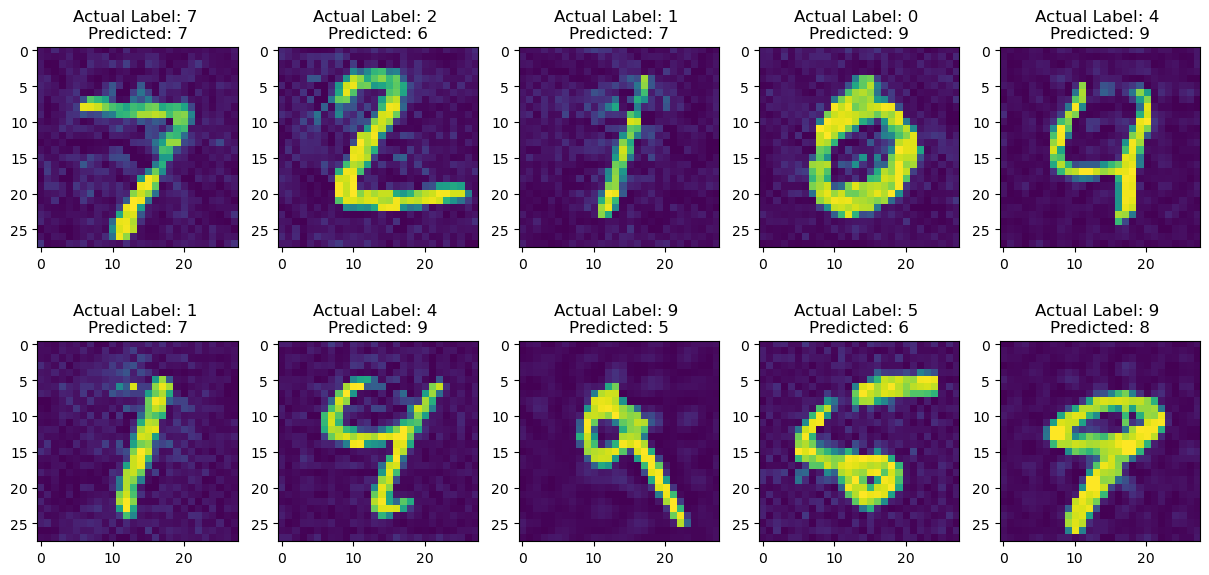

In [14]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()


for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  #im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {label.argmax()} \nPredicted: {model.predict(np.expand_dims(image, axis=0)).argmax()}",  fontsize=12)


#### Evaluate the trained model

In [15]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 8.20%
Average perturbation: 0.05


### Training the Detector

We create the second model using Keras API with the same strucure of the classifier. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics. This model will be used to classify between ordinary samples and perturbated ones

In [16]:
detector_model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

detector_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy']);

In [21]:
# Generating adversarail training data is time taking process. 
# So, we have decreased the number of samples to 500 to save time, 
# if you do not want to generate yourself, we have the saved data for your in the next chunk of cells. 
x_train_adv = attack.generate(x_train[:500])
nb_train = x_train[:500].shape[0]

x_train_detector = np.concatenate((x_train[:500], x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

In [17]:
# Load the data that is already trained. 
detector_data = np.load('./SimBA_data/SimBA_detector_mnist_data.npz')
x_train_detector, y_train_detector= detector_data['x_train_detector'], detector_data['y_train_detector']
x_train_detector.shape, y_train_detector.shape

((1000, 28, 28, 1), (1000, 2))

In [19]:
detector_model.fit(x_train_detector, y_train_detector, epochs=3)

Train on 1000 samples
Epoch 1/3
1000/1000 [==============================] - 0s 81us/sample - loss: 0.1851 - accuracy: 0.9360
Epoch 2/3
1000/1000 [==============================] - 0s 67us/sample - loss: 0.1678 - accuracy: 0.9440
Epoch 3/3
1000/1000 [==============================] - 0s 76us/sample - loss: 0.1720 - accuracy: 0.9420


Evaluate the adversarial generated data

In [28]:
x_test = x_test[:500]
nb_test = x_test.shape[0]

x_test_detector = np.concatenate((x_test, x_test_adv), axis=0)
y_test_detector = np.concatenate((np.array([[1,0]]*nb_test), np.array([[0,1]]*nb_test)), axis=0)

In [29]:
x_test_detector.shape, y_test_detector.shape

((1000, 28, 28, 1), (1000, 2))

In [30]:
loss_test, accuracy_test = detector_model.evaluate(x_test_detector, y_test_detector)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 96.00%


2024-05-24 08:57:10.798654: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_2/mul' id:1010 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [31]:
detector_classifier = KerasClassifier(clip_values=(0.0, 0.1), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [32]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=3, batch_size=32)

### Evaluating the detector

Apply the detector to the adversarial test data:

In [35]:
_, is_adversarial = detector.detect(x_test_adv)
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(500 - flag_adv))

Adversarial test data (first 100 images):
Flagged: 465
Not flagged: 35


Apply the detector to the first 100 original test images:

In [36]:
_, is_adversarial = detector.detect(x_test)
flag_original = np.sum(is_adversarial)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(500 - flag_original))

Original test data (first 100 images):
Flagged: 4
Not flagged: 496


Evaluate the detector for different attack strengths learning_rate (Note: for the training of detector, learning_rate=0.01 was used)

In [37]:
epsilon_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]
nb_flag_adv = []
nb_missclass = []


attack.set_params(**{'max_iter' : 10})

for rate in epsilon_range:
    attack.set_params(**{'epsilon': rate})
    x_test_adv = attack.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]

eps_range = [0] + epsilon_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

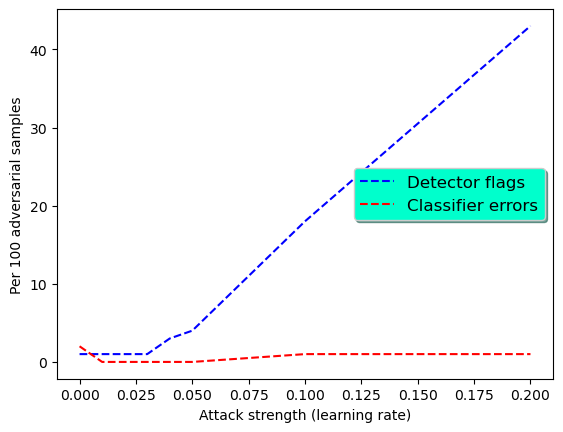

In [47]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (learning rate)')
plt.ylabel('Per 100 adversarial samples')
plt.show()

## **Summary**


#### Simple Black-box Adversarial Attack (SimBA) and Binary Input Detector Using MNIST-10

This notebook demonstrates the implementation of the SimBA attack using the Adversarial Robustness Toolbox (ART) against deep learning models trained on the MNIST-10 dataset. The tasks covered include:

1. **Load the Required Libraries:** Import necessary Python libraries and modules, including TensorFlow/Keras and ART.
2. **Load the Dataset and Inspect the Data:** Load and visualize the MNIST-10 dataset of handwritten digits (0-9).
3. **Create a Deep Learning Model:** Construct a CNN to classify MNIST-10 digits, including convolutional, pooling, and fully connected layers.
4. **Train and Evaluate the Model:** Train the CNN on MNIST-10 and evaluate its baseline accuracy on test data.
5. **Implement SimBA Attack Using ART:** Use ART to perform the SimBA attack, which perturbs images by flipping pixel signs based on model queries. SimBA is notable for its simplicity and effectiveness in black-box settings.
6. **Create Adversarial Samples Using SimBA:** Generate adversarial examples from the test images using SimBA and visually inspect them.
7. **Evaluate Against Adversarial Samples:** Test the model's robustness by evaluating its accuracy on the adversarial samples.
8. **Create a Detector Model:** Develop a binary classifier to detect adversarial inputs by differentiating between original and adversarial images.
9. **Train and Evaluate the Detector:** Train the detector using a labeled dataset of original and adversarial samples, and evaluate its accuracy in identifying adversarial attacks.

This summary highlights the process and key tasks involved in implementing the SimBA attack and developing a binary input detector using the MNIST-10 dataset, illustrating the importance of adversarial defenses in machine learning.